In [8]:
# install packages
#!pip install flashtext contractions seaborn scikit-learn
#!pip install --upgrade spacy==2.2.4

In [9]:
# install Spacy's language model
# python3 -m spacy download en_core_web_sm

# **Text preprocessing and dictionary methods**

This notebook makes use of the RawDocs class to illustrate a preprocessing pipeline for text data. Indeed, raw text typically needs to be cleaned before it can serve as input for a statistical model. 

As an example, we may want to split contractions, remove stopwords or remove punctuation. These steps can help a statistical model to only learn from terms that have a relevant meaning. 

We might also want to replace a term or a set of terms with another token. For instance, this operation could allow us to replace phrases (e.g. bigrams, trigrams) with single tokens.

Another common practice in text preprocessing is that of stemming (replacing words with their root) or lemmatizing (replacing words with their dictionary form i.e. lemma). These procedures bring words with the same root meaning back to a single token.

Finally, we might want to remove very frequent or infrequent words, and transform the data into a document-term matrix that can be fed into models that follow a bag-of-words approach.

In [10]:
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sys
from collections import Counter
import random
import ast

In [11]:
# define paths
data_path = "../data/"
pymodules_path = "../pymodules"

In [12]:
# import our own code
sys.path.append(pymodules_path)
import preprocessing_class as pc

### *0. Load data*

This tutorial uses text data from the **10-K reports** filed by most publicly-traded firms in the U.S. in 2019. 10-K reports are a very rich source of data since firms include information regarding their organizational structure, financial performance and risk factors. We will use a version of the data where the risk factors section of each report has been splitted into sentences and each sentence has been assigned an ID that combines the firm identifier (i.e. **CIK**) and a sentence number. The data we use has a total of 1,077,416 sentences for 2,500 firms.

More on the 10-K reports [here](https://www.investor.gov/introduction-investing/getting-started/researching-investments/how-read-10-k).

As a starting point, we will need to download two data files from Google Drive:
1. [10-K data](https://drive.google.com/file/d/1J7ECzsD3LDnU06B2CKK0vjgGenqI9kiw/view?usp=sharing) 
2. [Firm's 2019 data](https://drive.google.com/file/d/1vFcFJYdLD0sE_fbhGES8KQmvMcLuuCdc/view?usp=sharing) 

Once you download the two files put them in the *"data"* folder.

In [13]:
# load data parquet file (compressed format)
data = pd.read_parquet(data_path + "10k_sent_2019_sample.parquet")
print(data.shape)
data.head()

(1077416, 5)


,sentences,cik,year,sent_no,sent_id
0,You should carefully review the following disc...,1065088,2019,0,1065088_0
1,"Risk Factors That May Affect our Business, Res...",1065088,2019,1,1065088_1
2,Our operating and financial results are subjec...,1065088,2019,2,1065088_2
3,Our operating and financial results have varie...,1065088,2019,3,1065088_3
4,It is difficult for us to forecast the level o...,1065088,2019,4,1065088_4


In [14]:
# if we have some memory (or time) limitation we can take a subsample of the data for the analysis
# seed = 92
# data = data.sample(500000, random_state=seed)
# data.reset_index(drop=True, inplace=True)

In [15]:
# get a rough sense of the length of sentences and the number of firms in the data
data['length'] = data["sentences"].apply(lambda x: len(x.split()))
print(f'Average sentence length: {np.round(np.mean(data.length), 0)} words')
print(f"Total number of firms represented in the data: {len(data.groupby('cik').size())}")

Average sentence length: 27.0 words
Total number of firms represented in the data: 2500


### *1. Initialize class with documents and main parameters*

We instantiate the ```RawDocs``` class by passing a pandas series containing the raw documents. We also provide some main parameters that will define the way in which the text is cleaned and tokenized. 

The list of stopwords will be saved into the ```.stopwords``` attribute. We can go for the "long" list (retrieved from [here](https://snowballstem.org/algorithms/english/stop.txt)) or the "short" list (a subsample defined as in Hansen, McMahon, and Prat (2014) ). We can also pass a customized list, or no list at all (we are always free to add it later on by modifying the ```stopwords``` attribute).

By setting the "contraction_split" argument to ```True```, we will also expand English contractions to their extended form (e.g. "doesn't" to "does not"). 

Finally, "tokenization_pattern" allows us to pass a custom regular expression in order to break-up documents into tokens.

In [16]:
pattern = r'''
          (?x)                # set flag to allow verbose regexps (to separate logical sections of pattern and add comments)
          \w+(?:-\w+)*        # preserve expressions with internal hyphens as single tokens
          | [][.,;"'?():-_`]  # preserve punctuation as separate tokens
          '''

In [17]:
prep = pc.RawDocs(data["sentences"],            # series of documents
                  lower_case=True,              # whether to lowercase the text in the firs cleaning step 
                  stopwords='long',             # type of stopwords to initialize
                  contraction_split=True,       # wheter to split contractions or not
                  tokenization_pattern=pattern  # custom tokenization patter
                  )

In [18]:
# notice that the documents from the object are identical to the ones from the pandas series
i = 20
print("Document from the pandas series:\n", data.loc[i, "sentences"])
print("\n-------------------------\n")
print("Document from preprocessing object:\n", prep.docs[i])

Document from the pandas series:
 As we respond to changes in the competitive environment, we may, from time to time, make pricing, service or marketing decisions or acquisitions that may be controversial with and lead to dissatisfaction among sellers, which could reduce activity on our platform and harm our profitability.

-------------------------

Document from preprocessing object:
 As we respond to changes in the competitive environment, we may, from time to time, make pricing, service or marketing decisions or acquisitions that may be controversial with and lead to dissatisfaction among sellers, which could reduce activity on our platform and harm our profitability.


### *2. Replace phrases with single token*

We will start our preprocessing process by replacing specific words or phrases with a pre-defined token. The purpose of this is to preserve these expressions for later stages of our analysis.  The ```phrase_replace()``` method from the RawDocs class allows us to do this. In particular, it will replace the keys with the values of a user-defined dictionary. Let's give it a try:

In [19]:
# we can build a manual dictionary with the expressions we want to replace in the text
manual_replacing_dict = {"financial intermediation": "financial-intermediation-token",
                         "interest rate": "interest-rate-token",
                         "interest rates": "interest-rate-token",
                         "Apple": "apple-token",
                         "Federal Reserve Board": "fed-token",
                         "FED": "fed-token",
                         }

In [20]:
# however we will build a dictionary by loading a list of words and phrases (i.e expressions) and generating the tokens with which we will replace them
df_replace = pd.read_csv(data_path + "replacement_expressions.txt", sep="\t")
df_replace.head()

,expression
0,Federal Agricultural Mortgage Corporation
1,early childhood development program
2,unemployment insurance
3,workers’ compensation
4,FCC


In [21]:
# get unique expressions and capture their length
replace_exp = list(df_replace["expression"].values)
replace_exp = list(set(replace_exp))
replace_exp = [x.strip() for x in replace_exp]
replace_exp = np.array(list(set(replace_exp)))
# we capture the length of the expression in order to determine the order of substitution
# more on this later
len_replace = np.array([len(p.split()) for p in replace_exp])

In [22]:
# generate replacement token by hyphenating the words in the expressions and lower casing them
def token_make(expression, signal_word):
    words = expression.split(" ")
    # add a word at the end of the expression
    words.append(signal_word)
    single_token = "-".join(words)
    return single_token.lower()

# generate tokens for expressions of all length
replace_dicts = {}
for i in Counter(len_replace).keys():
    exps = replace_exp[np.where(len_replace == i)]
    replace_dicts[i] = {e: token_make(e, 'token') for e in exps}

In [23]:
# explore some of the expressions and their replacement tokens
list(replace_dicts[3].items())[0:10]

[('alcohol fuel credit', 'alcohol-fuel-credit-token'),
 ('right to work', 'right-to-work-token'),
 ('Tennessee Valley Authority', 'tennessee-valley-authority-token'),
 ('Department of Education', 'department-of-education-token'),
 ('Internal Revenue Service', 'internal-revenue-service-token'),
 ('Federal Aviation Administration', 'federal-aviation-administration-token'),
 ('Section 8 Housing', 'section-8-housing-token'),
 ('Federal Highway Administration', 'federal-highway-administration-token'),
 ('Federal Communications Commission',
  'federal-communications-commission-token'),
 ('clean air act', 'clean-air-act-token')]

In [24]:
# explore a document with phrases that will be replaced
i = 107915
print("Document before phrase replacing:\n", prep.docs[i])

Document before phrase replacing:
 Congress adopted comprehensive financial reform legislation under the Dodd-Frank Act that establishes federal oversight and regulation of the over-the-counter derivatives market and entities, such as us, that participate in that market.


Now that we have the replacement dictionary ready we will use the ```phrase_replace()``` method to apply it to our text. Crucially, we will not replace all expressions at the same time but, instead, we will do the replacements according to the number of words in each expression. We will follow a descending order of replacement so that we preserve longer expressions first and then move to the rest.

In [25]:
# apply phrase replacing in order according to the length of the expression
# we want to replace longer expressions first
for tokens_len in range(max(replace_dicts.keys()), 0, -1):
    dict_len = replace_dicts[tokens_len]
    print(f"Replacing expressions of length {tokens_len} such as:\n {random.choice(list(dict_len.keys()))}")
    # apply method from class
    prep.phrase_replace(replace_dict=dict_len, case_sensitive_replacing=False)

Replacing expressions of length 7 such as:
 Office of Fair Housing and Equal Opportunity
Replacing expressions of length 6 such as:
 Pipeline and Hazardous Materials Safety Administration
Replacing expressions of length 5 such as:
 National Highway Traffic Safety Administration
Replacing expressions of length 4 such as:
 house financial services committee
Replacing expressions of length 3 such as:
 capital gains tax
Replacing expressions of length 2 such as:
 trademark infringement
Replacing expressions of length 1 such as:
 dumping


Notice that several expressions were replaced throughout the sentence with a single new token (e.g. financial reform with financial-reform-token).

In [26]:
print("Document after phrase replacing:\n", prep.docs[i])

Document after phrase replacing:
 Congress adopted comprehensive financial-reform-token legislation under the dodd-frank-token Act that establishes federal oversight and regulation-token of the over-the-counter derivatives market and entities, such as us, that participate in that market.


### *3. Lower-case, split contractions and tokenize*

After succesfully extracting and replacing the phrases we needed we can now move on and apply some basic cleaning to the text. This is done through the ```basic_cleaning()``` method which will use some of the parameters provided in the initialization of the class. Using this method, the text can be lower-cased, contractions can be expanded and a list of stopwords can be initialized.

Finally, we will then use the ```tokenize_text()``` method to split documents into tokens using the custom pattern we provided earlier. It is very important that we use a tokenization pattern that preserves hyphenated words together since we used the hyphen when replacing phrases earlier. Passing a tokenization pattern will override the default tokenization algorithm with a user-defined tokenization routine based on a specific regular expression. In our case, we pass a regex that ensures e.g. not to tokenize over hyphens, currency or percentage signs. 

After applying this method, our preprocessing object (```prep```) will get a new attribute that we can access: ```.tokens```.

In [27]:
# lower-case text, expand contractions and initialize stopwords list
prep.basic_cleaning()

In [28]:
# explore an example after the basic cleaning has been applied
i = 107915
print(data.loc[i, "sentences"])
print()
print(prep.docs[i])

Congress adopted comprehensive financial reform legislation under the Dodd-Frank Act that establishes federal oversight and regulation of the over-the-counter derivatives market and entities, such as us, that participate in that market.

congress adopted comprehensive financial-reform-token legislation under the dodd-frank-token act that establishes federal oversight and regulation-token of the over-the-counter derivatives market and entities, such as us, that participate in that market.


In [29]:
# now we can split the documents into tokens
prep.tokenize_text()

Below, we show a random document and its tokenized version. As we can see, text was tokenized in such a way that expressions replaced previously such as "financial-reform-token" were kept as a single token. Notice also that punctuation symbols were preserved.

In [30]:
i = 107915
print(data.loc[i, "sentences"])
print()
print(prep.tokens[i])

Congress adopted comprehensive financial reform legislation under the Dodd-Frank Act that establishes federal oversight and regulation of the over-the-counter derivatives market and entities, such as us, that participate in that market.

['congress', 'adopted', 'comprehensive', 'financial-reform-token', 'legislation', 'under', 'the', 'dodd-frank-token', 'act', 'that', 'establishes', 'federal', 'oversight', 'and', 'regulation-token', 'of', 'the', 'over-the-counter', 'derivatives', 'market', 'and', 'entities', ',', 'such', 'as', 'us', ',', 'that', 'participate', 'in', 'that', 'market', '.']


At this point, tokens could be ready to use for some specific aims. For instance, one might want to count instances of specific terms, including punctuation. However, more often one wants to proceed with heavier preprocessing, for which other methods of the RawDocs class can prove useful.

### *4. Remove non-ASCII symbols, punctuation, numbers, short tokens*

The ```token_clean()``` method iterates over tokens and removes elements that we might consider unnecessary or impairing our analysis.

The method automatically removes non-ASCII characters. In addition, we can remove punctuation, numbers and tokens with a number of characters lower than or equal to "length". The function removes by default the punctuation included in the string package:

In [31]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

However, we are free to pass a customised punctuation string. Here, we pass the string above excluding hypens.

In [32]:
punctuation = string.punctuation
punctuation = punctuation.replace("-", "") # remove the hyphen from the punctuation string
punctuation

'!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [33]:
prep.token_clean(length=2,                 # remove tokens with less than this number of characters 
                 punctuation=punctuation,  # remove custom list of punctuation characters
                 numbers=True              # remove numbers
                 )

Let's now look at our document again

In [34]:
i = 107915
print(data.loc[i, "sentences"])
print()
print(prep.tokens[i])

Congress adopted comprehensive financial reform legislation under the Dodd-Frank Act that establishes federal oversight and regulation of the over-the-counter derivatives market and entities, such as us, that participate in that market.

['congress', 'adopted', 'comprehensive', 'financial-reform-token', 'legislation', 'under', 'the', 'dodd-frank-token', 'act', 'that', 'establishes', 'federal', 'oversight', 'and', 'regulation-token', 'the', 'over-the-counter', 'derivatives', 'market', 'and', 'entities', 'such', 'that', 'participate', 'that', 'market']


### *5. Remove stopwords*

The ```remove_stopwords()``` method allows to remove tokens included in the "stopwords" attribute. We went for the "long" stopwords list, that is printed below.

In [35]:
# get the list of stopwords provided earlier
print(sorted(prep.stopwords))

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'also', 'am', 'an', 'and', 'another', 'any', 'are', 'as', 'at', 'back', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'could', 'did', 'do', 'does', 'doing', 'down', 'during', 'each', 'even', 'ever', 'every', 'few', 'first', 'five', 'for', 'four', 'from', 'further', 'get', 'go', 'goes', 'had', 'has', 'have', 'having', 'he', 'her', 'here', 'hers', 'herself', 'high', 'him', 'himself', 'his', 'how', 'however', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'itself', 'just', 'least', 'less', 'like', 'long', 'made', 'make', 'many', 'me', 'more', 'most', 'my', 'myself', 'never', 'new', 'no', 'nor', 'not', 'now', 'of', 'off', 'old', 'on', 'once', 'one', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'put', 'said', 'same', 'say', 'says', 'second', 'see', 'seen', 'she', 'should', 'since', 'so', 'some', 'still', 'such', 'take', 'than', 'that', 'the', 'their', 'theirs'

In [36]:
# we need to specificy that we want to remove the stopwords from the "tokens"
prep.stopword_remove('tokens')

As we can see, after applying the ```stopwords_remove()``` method, tokens like "the" or "of" have been dropped.

In [37]:
i = 107915
print(data.loc[i, "sentences"])
print()
print(prep.tokens[i])

Congress adopted comprehensive financial reform legislation under the Dodd-Frank Act that establishes federal oversight and regulation of the over-the-counter derivatives market and entities, such as us, that participate in that market.

['congress', 'adopted', 'comprehensive', 'financial-reform-token', 'legislation', 'dodd-frank-token', 'act', 'establishes', 'federal', 'oversight', 'regulation-token', 'over-the-counter', 'derivatives', 'market', 'entities', 'participate', 'market']


### *6. Stem or lemmatize*

As a next step, one might attempt to group together words that are grammatically different but thematically identical. For example, it could be reasonable to keep words such as *"obligations"*, *"obligation"* and  *"oblige"* under a single token. Ultimately these three words denote the same concept, and so we might want them to share the same symbol. 

The two most popular techniques to achieve this goal are **stemming** and **lemmatization**.  Stemming replaces each word with its root form. The resulting token is less readable by humans but encompases multiple words (e.g. *"tradition"* and *"traditional"* have the same stem: *"tradit"*). Lemmatization replaces words with their dictionary form i.e. lemma. The words *"changing"*, *"changes"* and *"changed"* all have the same lemma: *"change"*.

The ```RawDocs``` class allows both stemming (via nltk Snowball stemmer) and lemmatization (via spaCy lemmatizer). Below, we use both techniques and look at the different results on a specific document. Stems and lemmas are stored in the "stems" and "lemmas" attributes respectively.

In [38]:
# apply stemming to all documents
prep.stem()

In [39]:
# apply lemmatization to all documents (takes a very long time so we will avoid it for now)
# prep.lemmatize()

In [40]:
# compare all versions of the same raw sentences
i = 107915
print(data.loc[i, "sentences"])
print()
print(prep.tokens[i])
print()
print(prep.stems[i])
print()
#print(prep.lemmas[i])

Congress adopted comprehensive financial reform legislation under the Dodd-Frank Act that establishes federal oversight and regulation of the over-the-counter derivatives market and entities, such as us, that participate in that market.

['congress', 'adopted', 'comprehensive', 'financial-reform-token', 'legislation', 'dodd-frank-token', 'act', 'establishes', 'federal', 'oversight', 'regulation-token', 'over-the-counter', 'derivatives', 'market', 'entities', 'participate', 'market']

['congress', 'adopt', 'comprehens', 'financial-reform-token', 'legisl', 'dodd-frank-token', 'act', 'establish', 'feder', 'oversight', 'regulation-token', 'over-the-counter', 'deriv', 'market', 'entiti', 'particip', 'market']



### *7. Term ranking*

Finally, one might want to drop very frequent terms, as they could be regarded as corpus-specific stopwords that do not add up much value. Similarly, one might want to drop very rare terms, considering that not much can be learnt from such infrequent items. 

To explore these ideas, the ```get_term_ranking()``` method comes in handy. It allows to rank items (either tokens, stems or lemmas) according to pure **document frequency (df)** or to **term frequency inverse document frequency (tf-idf)**; where we give a large weight to terms that appear frequently in the entire dataset, but in relatively few documents. In particular, the tf-idf score for term $v$ is computed according to the formula below:

\begin{equation}
tfidf_v = (1+log(tf_v)) (log \frac{N}{df_v + 1})
\end{equation}

Results are stored in the ```df_ranking``` and ```tfidf_ranking``` attributes respectively, and come as a list of tuples of the form (score, term, ranking position). 
Let's now look at the top ranked tokens in terms of document frequency:

In [41]:
prep.get_term_ranking(items='tokens', score_type='df')
prep.df_ranking['tokens'][:15]

[(308155.0, 'may', 0),
 (147726.0, 'business', 1),
 (106719.0, 'financial', 2),
 (100666.0, 'operations', 3),
 (100517.0, 'will', 4),
 (86754.0, 'results', 5),
 (82080.0, 'including', 6),
 (80152.0, 'products', 7),
 (78884.0, 'result', 8),
 (76608.0, 'future', 9),
 (72275.0, 'ability', 10),
 (67167.0, 'adversely', 11),
 (64749.0, 'market', 12),
 (62428.0, 'subject', 13),
 (60660.0, 'affect', 14)]

As we can see, tokens such as "business" or "financial" rank very high with document frequencies of 147,726 and 106,719 respectively out of 1,077,416 documents (i.e. "business" is present in around 14% of the documents and "financial" in 10%)

Let's now look at the top ranked tokens in terms of tf-idf:

In [42]:
prep.get_term_ranking(items='tokens', score_type='tfidf')
prep.tfidf_ranking['tokens'][:10]

[(60.97096036848512, 'kaleyra', 0),
 (60.15888517721545, 'figr', 1),
 (59.85425198965002, 'jtx-', 2),
 (59.64041224434897, 'mereo', 3),
 (59.41517415039296, 'nep', 4),
 (59.3929465971522, 'xmab', 5),
 (59.066910853588354, 'sulopenem', 6),
 (58.9436385692586, 'circular', 7),
 (58.80973653418351, 'hmi-', 8),
 (58.748353858224185, 'turning', 9)]

As we can see, the two methods differ considerably in how they rank tokens. Indeed, tf-idf weights more those terms that are frequent, but appear in relatively few documents. Consequently, names of companies get highly weighted (e.g. [Kaleyra](https://www.kaleyra.com/), [NEP](https://www.nepgroup.com/country/united-states), [Mereo](https://www.mereobiopharma.com/), [FIGR](https://www.figr.com/)) since they appear only in few documents (probably only the sentences from the 10-K report of the company) but are used very frequently in those documents. What would happen if we aggregate sentences at the firm-level and calculate tf-idf scores again?

If instead we look at the bottom-ranked tokens, we see that there is considerably more agreement between the two methods:

In [43]:
prep.df_ranking['tokens'][-10:]

[(1.0, 'zugibe', 2603),
 (1.0, 'zur', 2603),
 (1.0, 'zurn', 2603),
 (1.0, 'zvex-based', 2603),
 (1.0, 'zwillinger', 2603),
 (1.0, 'zyban', 2603),
 (1.0, 'zymeworks', 2603),
 (1.0, 'zymogenic', 2603),
 (1.0, 'zynga', 2603),
 (1.0, 'zyxel', 2603)]

In [44]:
prep.tfidf_ranking['tokens'][-15:]

[(13.196928959124534, 'zostavax', 7097),
 (13.196928959124534, 'zoster', 7097),
 (13.196928959124534, 'zotrip', 7097),
 (13.196928959124534, 'zpharm', 7097),
 (13.196928959124534, 'zpl', 7097),
 (13.196928959124534, 'zubsolv', 7097),
 (13.196928959124534, 'zugibe', 7097),
 (13.196928959124534, 'zur', 7097),
 (13.196928959124534, 'zurn', 7097),
 (13.196928959124534, 'zvex-based', 7097),
 (13.196928959124534, 'zwillinger', 7097),
 (13.196928959124534, 'zyban', 7097),
 (13.196928959124534, 'zymeworks', 7097),
 (13.196928959124534, 'zynga', 7097),
 (13.196928959124534, 'zyxel', 7097)]

Let's now inspect the overall behavior of the document frequency ranking and the tf-idf ranking. As we can see, document frequency decays very fast (following a power-law), while tf-idf decreases at a slower pace.

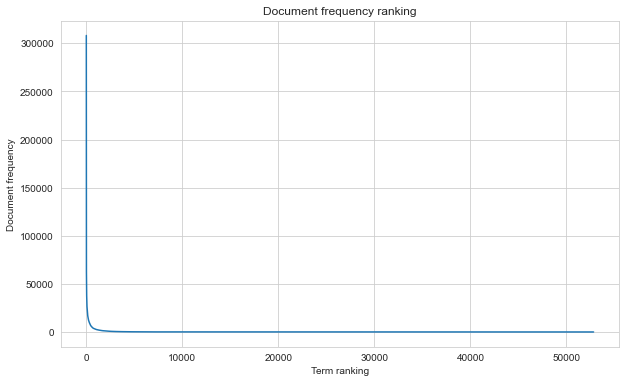

In [45]:
plt.figure(figsize=(10,6))
plt.plot([x[0] for x in prep.df_ranking['tokens']])
plt.title('Document frequency ranking')
plt.ylabel("Document frequency")
plt.xlabel("Term ranking")
plt.show()

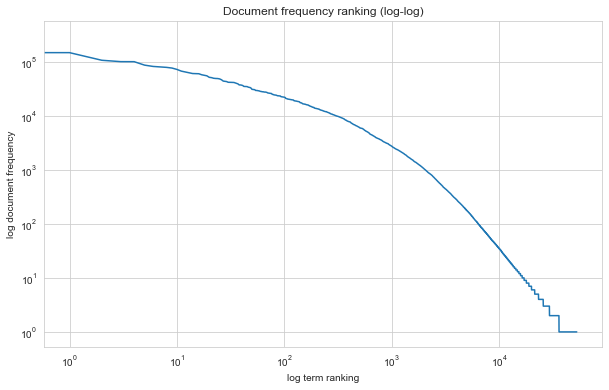

In [46]:
# we can use a log-log scale to observe more clearly the power-law distribution (Zipf's law)
plt.figure(figsize=(10,6))
plt.loglog([x[0] for x in prep.df_ranking['tokens']])
plt.title('Document frequency ranking (log-log)')
plt.ylabel("log document frequency")
plt.xlabel("log term ranking")
plt.show()

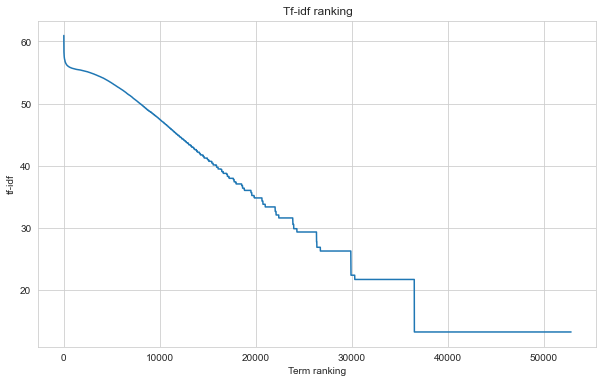

In [47]:
plt.figure(figsize=(10,6))
plt.plot([x[0] for x in prep.tfidf_ranking['tokens']])
plt.title('Tf-idf ranking')
plt.ylabel("tf-idf")
plt.xlabel("Term ranking")
plt.show()

### *8. Vectorization*

Now that we have finished pre-processing our text we will use the python library **Scikit-learn** to transform our list of tokens, lemmas or stems into numerical matrices. We will call this new representation of the text a **document-term** matrix. This matrix, can be used as the input to many bag-of-words text analysis algorithms such as dictionary methods, word2vec, Latent Semantic Analysis (LSA) or Linear Dirichlet Allocation (LDA).

Check the documentation for the [```CountVectorizer```](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and the [```TfidfVectorizer```](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) to explore all the parameters and functionalities of these classes. Although this notebook extensively uses a custom preprocessing pipeline, one can also rely on the preprocessing tools available on these classes. 

In [48]:
# # create a CountVectorizer object straight from the raw text
# count_vectorizer = CountVectorizer(encoding='utf-8',
#                                    token_pattern=pattern,
#                                    lowercase=True,
#                                    strip_accents="ascii",
#                                    stop_words="english", 
#                                    ngram_range=(1, 1),       # generate only unigrams
#                                    analyzer='word',          # analysis at the word-level 
#                                    max_df=0.5,              # ignore tokens that have a higher document frequency (can be int or percent)
#                                    min_df=20,                # ignore tokens that have a lowe document frequency (can be int or percent)
#                                    max_features=None,        # we could impose a maximum number of vocabulary terms
#                                    )
                                   
# # transform our preprocessed tokens into a document-term matrix
# dt_matrix_raw = count_vectorizer.fit_transform(data["sentences"])
# print(f"Document-term matrix created with shape: {dt_matrix_raw.shape}")

In [49]:
# simple auxiliary function to override the preprocessing done by sklearn
def do_nothing(doc):
    return doc

In [50]:
# create a CountVectorizer object using our preprocessed text
count_vectorizer = CountVectorizer(encoding='utf-8', 
                                   preprocessor=do_nothing,  # apply no additional preprocessing
                                   tokenizer=do_nothing,     # apply no additional tokenization
                                   lowercase=False,
                                   strip_accents=None,
                                   stop_words=None, 
                                   ngram_range=(1, 1),       # generate only unigrams
                                   analyzer='word',          # analysis at the word-level 
                                   max_df=0.5,              # ignore tokens that have a higher document frequency (can be int or percent)
                                   min_df=500,                # ignore tokens that have a lowe document frequency (can be int or percent)
                                   max_features=None,        # we could impose a maximum number of vocabulary terms
                                   )

In [51]:
# transform our preprocessed tokens into a document-term matrix
dt_matrix = count_vectorizer.fit_transform(prep.tokens)
print(f"Document-term matrix created with shape: {dt_matrix.shape}")

Document-term matrix created with shape: (1077416, 2972)


In [52]:
# we can access a dictionary that maps between words and positions of the document-term matrix
list(count_vectorizer.vocabulary_.items())[0:10]

[('carefully', 372),
 ('review', 2425),
 ('following', 1174),
 ('discussion', 841),
 ('risks', 2440),
 ('may', 1705),
 ('affect', 94),
 ('business', 338),
 ('results', 2412),
 ('operations', 1878)]

In [53]:
# check that our replaced expressions are part of the vocabulary
print(f"Position of {'interest-rate-token'} in document-term matrix: {count_vectorizer.vocabulary_['interest-rate-token']}")
print(f"Position of {'taxes-token'} in document-term matrix: {count_vectorizer.vocabulary_['taxes-token']}")

Position of interest-rate-token in document-term matrix: 1478
Position of taxes-token in document-term matrix: 2703


### *9. Example of dictionary methods*

In this last section, we will show how to use the document-term matrix for a simple analysis. We will use several term sets developed by [Baker et al. (2019)](https://www.nber.org/system/files/working_papers/w25720/w25720.pdf) to capture a variety of broad thematic categories in newspaper articles. These categories include topics such as financial regulation, taxation, healthcare and commodities.

The overall idea is to use the words that describe each one of these categories to analyze how firms are exposed to each on of these issues. Furthermore, we would want to understand how this exposition varies according to some main characteristics of firms (e.g. secotor, size).

It is worth highlighting that the main motivation behind the phrase replacing step we perfomed earlier was to preserve all of the expressions included in the term sets developed by Baker et al. (2019).

In [54]:
# open the sets of terms from Baker et al. (2019)
file = open(data_path + "broad_term_dictionaries_clean.txt", "r")
contents = file.read()
dictionary = ast.literal_eval(contents)
file.close()

In [55]:
# adjust the term sets to match our tokens (i.e. replace _ with -)
clean_dictionaries = {}
for k,v in dictionary.items():
    print(f"Cleaning {len(v)} tokens for topic: {k}")
    clean_dictionaries[k] = [token.replace("_", "-") for token in v]

Cleaning 13 tokens for topic: list_broad_quantity
Cleaning 33 tokens for topic: list_commodity
Cleaning 17 tokens for topic: list_competition
Cleaning 5 tokens for topic: list_consumer
Cleaning 13 tokens for topic: list_elections
Cleaning 10 tokens for topic: list_exchange_rate
Cleaning 9 tokens for topic: list_financial_crisis
Cleaning 15 tokens for topic: list_govt_enterprises
Cleaning 22 tokens for topic: list_govt_spending
Cleaning 22 tokens for topic: list_healthcare
Cleaning 7 tokens for topic: list_inflation
Cleaning 7 tokens for topic: list_interest_rates
Cleaning 4 tokens for topic: list_invest_sentiment
Cleaning 8 tokens for topic: list_ip
Cleaning 7 tokens for topic: list_labor_disputes
Cleaning 17 tokens for topic: list_labor_markets
Cleaning 10 tokens for topic: list_litigation
Cleaning 31 tokens for topic: list_monetary
Cleaning 11 tokens for topic: list_other_financial
Cleaning 2 tokens for topic: list_policy_agri
Cleaning 4 tokens for topic: list_policy_food
Cleaning 26

In [56]:
# we will focus only on some of the categories for the current analysis
taxes_dict = clean_dictionaries["list_taxes"]
commodity_dict = clean_dictionaries["list_commodity"]
healthcare_dict = clean_dictionaries["list_healthcare"]
monetary_dict = clean_dictionaries["list_monetary"]
trade_dict = clean_dictionaries["list_policy_trade"]
reg_finance_dict = clean_dictionaries["list_reg_finance"]
elections_dict = clean_dictionaries["list_elections"]
regulation_dict = clean_dictionaries["list_reg_generic"]

In [57]:
# explore the tokens in the term sets
print("Taxes dictionary:")
print(taxes_dict)
print("\n-------------------\n")
print("Healthcare dictionary:")
print(healthcare_dict)
print("\n-------------------\n")
print("Commodities dictionary:")
print(commodity_dict)
print("\n-------------------\n")

Taxes dictionary:
['taxes-token', 'tax-token', 'taxation-token', 'tax-token', 'income-tax-token', 'tax-on-individual-token', 'personal-tax-token', 'capital-gain-tax-token', 'tax-on-capital-gain-token', 'dividend-tax-token', 'mortgage-interest-deduction-token', 'deduction-for-mortgage-interest-token', 'ira-account-token', 'roth-ira-token', 'traditional-ira-token', '401-k-token', 'state-and-local-tax-deduction-token', 'deductibility-of-state-and-local-tax-token', 'payroll-tax-token', 'social-security-tax-token', 'social-security-contribution-token', 'medicare-taxis-token', 'fica-token', 'unemployment-tax-token', 'futa-token', 'sale-tax-token', 'excise-tax-token', 'value-add-tax-token', 'vat-token', 'good-and-service-tax-token', 'gross-receipt-tax-token', 'corporate-tax-token', 'business-tax-token', 'profit-tax-token', 'investment-tax-credit-token', 'accelerate-depreciation-token', 'r-d-tax-credit-token', 'research-and-development-tax-credit-token', 'tax-credit-for-low-income-housing-toke

In [58]:
# find the position in the vocabulary of all terms
taxes_idxs = [v for k,v in count_vectorizer.vocabulary_.items() if k in taxes_dict]
print(f"{len(taxes_idxs)} tokens found in vocabulary for taxes dictionary")

commodity_idxs = [v for k,v in count_vectorizer.vocabulary_.items() if k in commodity_dict]
print(f"{len(commodity_idxs)} tokens found in vocabulary for commodity dictionary")

healthcare_idxs = [v for k,v in count_vectorizer.vocabulary_.items() if k in healthcare_dict]
print(f"{len(healthcare_idxs)} tokens found in vocabulary for healthcare dictionary")

monetary_idxs = [v for k,v in count_vectorizer.vocabulary_.items() if k in monetary_dict]
print(f"{len(monetary_idxs)} tokens found in vocabulary for monetary dictionary")

trade_idxs = [v for k,v in count_vectorizer.vocabulary_.items() if k in trade_dict]
print(f"{len(trade_idxs)} tokens found in vocabulary for trade dictionary")

reg_finance_idxs = [v for k,v in count_vectorizer.vocabulary_.items() if k in reg_finance_dict]
print(f"{len(reg_finance_idxs)} tokens found in vocabulary for financial regulation dictionary")

elections_idxs = [v for k,v in count_vectorizer.vocabulary_.items() if k in elections_dict]
print(f"{len(elections_idxs)} tokens found in vocabulary for elections dictionary")

regulation_idxs = [v for k,v in count_vectorizer.vocabulary_.items() if k in regulation_dict]
print(f"{len(regulation_idxs)} tokens found in vocabulary for generic regulation dictionary")

7 tokens found in vocabulary for taxes dictionary
7 tokens found in vocabulary for commodity dictionary
6 tokens found in vocabulary for healthcare dictionary
1 tokens found in vocabulary for monetary dictionary
1 tokens found in vocabulary for trade dictionary
6 tokens found in vocabulary for financial regulation dictionary
1 tokens found in vocabulary for elections dictionary
3 tokens found in vocabulary for generic regulation dictionary


In [59]:
# count the total number of appearances of the tokens in each category per document
taxes_counts = dt_matrix.tocsr()[:, taxes_idxs]
taxes_counts = taxes_counts.sum(axis=1)

commodity_counts = dt_matrix.tocsr()[:, commodity_idxs]
commodity_counts = commodity_counts.sum(axis=1)

reg_finance_counts = dt_matrix.tocsr()[:, reg_finance_idxs]
reg_finance_counts = reg_finance_counts.sum(axis=1)

healthcare_counts = dt_matrix.tocsr()[:, healthcare_idxs]
healthcare_counts = healthcare_counts.sum(axis=1)

monetary_counts = dt_matrix.tocsr()[:, monetary_idxs]
monetary_counts = monetary_counts.sum(axis=1)

In [60]:
# add counts to structured data
data['taxes_counts'] = taxes_counts
data['commodity_counts'] = commodity_counts
data['reg_finance_counts'] = reg_finance_counts
data['healthcare_counts'] = healthcare_counts
data['monetary_counts'] = monetary_counts

Our structured data now includes the number of tokens from each category that were found in each document.

In [61]:
data.head()

TypeError: unsupported format string passed to matrix.__format__

TypeError: unsupported format string passed to matrix.__format__

In [62]:
# aggregate at the firm level
data_agg = data.groupby(['cik'], as_index=False).agg({'taxes_counts': 'sum', 'commodity_counts': 'sum', 'reg_finance_counts': 'sum', 
                                                      'healthcare_counts': 'sum', 'monetary_counts': 'sum'})
print(data_agg.shape)
data_agg.head()

AssertionError: 0

In [ ]:
# load additional data for firms
covariates = pd.read_csv(data_path + "covariates_2019.csv")
covariates.head()

In [ ]:
# merge new data to firm level counts
data_agg = pd.merge(data_agg, covariates, how="inner", on="cik")
data_agg.head()

#### **Counts per NAICS2 sector**

Now that we have consolidate the counts of some of the different thematic categories at the firm level, we can analyse how the exposure to these themes varies according to a firm's sector.

In [ ]:
# calculate the average number of tokens per sector
data_sector = data_agg[["naics2_name" ,"taxes_counts", "commodity_counts", "reg_finance_counts", "healthcare_counts", "monetary_counts"]].groupby("naics2_name", as_index=False).mean()
data_sector

In [ ]:
# visualize table as heatmap
data_plot = data_sector.set_index("naics2_name")
plt.figure(figsize=(16,10))
sns.heatmap(data_plot, annot=True, fmt="g", cmap='viridis')
plt.show()

In [ ]:
# plot according to exposure to topic
df_plot = data_sector.sort_values("commodity_counts", ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(data=df_plot, x="commodity_counts", y="naics2_name", palette="Blues_r")
plt.title("Commodities topic")
plt.xlabel("Average number of tokens from topic per firm")
plt.ylabel("Sector")
plt.show()

In [ ]:
data_construction = data_agg.loc[data_agg["naics2_name"] == "Construction"]
data_construction.sort_values("commodity_counts", ascending=False).head()

If we look at the first two firms from the Construction sector that have the most counts from the Commodities topic we see that they are part of the NAICS sector that correspond to *Oil and Gas Pipeline and Related Structures Construction* (237120). This is very interesting since, although they are construction firms they work with gas and oil and, thus, have a high number of counts in the commodities topic.

In [ ]:
# plot according to exposure to topic
df_plot = data_sector.sort_values("reg_finance_counts", ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(data=df_plot, x="reg_finance_counts", y="naics2_name", palette="Blues_r")
plt.title("Financial regulation topic")
plt.xlabel("Average number of tokens from topic per firm")
plt.ylabel("Sector")
plt.show()

In [ ]:
# plot according to exposure to topic
df_plot = data_sector.sort_values("monetary_counts", ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(data=df_plot, x="monetary_counts", y="naics2_name", palette="Blues_r")
plt.title("Monetary topic")
plt.xlabel("Average number of tokens from topic per firm")
plt.ylabel("Sector")
plt.show()

In [ ]:
# plot according to exposure to topic
df_plot = data_sector.sort_values("healthcare_counts", ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(data=df_plot, x="healthcare_counts", y="naics2_name", palette="Blues_r")
plt.title("Healthcare topic")
plt.xlabel("Average number of tokens from topic per firm")
plt.ylabel("Sector")
plt.show()

In [ ]:
# plot according to exposure to topic
df_plot = data_sector.sort_values("taxes_counts", ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(data=df_plot, x="taxes_counts", y="naics2_name", palette="Blues_r")
plt.title("Taxation topic")
plt.xlabel("Average number of tokens from topic per firm")
plt.ylabel("Sector")
plt.show()